第一个代码单元格（安装依赖）：

In [1]:
# 安装必要的库
!pip install transformers datasets torch scikit-learn pandas tqdm psutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

第二个代码单元格（导入库）：

In [4]:
# 导入必要的库
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
import time
import psutil
import gc
from torch.cuda.amp import autocast, GradScaler

## 1. 挂载 Google Drive 并设置工作目录

In [5]:
# 挂载 Google Drive
drive.mount('/content/drive')

# 创建保存结果的目录
!mkdir -p "/content/drive/MyDrive/mixed_precision_results"

Mounted at /content/drive


## 2. 准备数据集

In [6]:
# 创建示例数据
texts = [
    "这部电影很精彩，演员的表演非常出色",
    "画面很差，故事情节也很烂",
    "音乐很动听，节奏感很强",
    "服务态度恶劣，等了很久才上菜",
    "风景优美，空气清新，是个度假的好地方",
    "价格太贵了，性价比很低",
    "质量不错，用着很舒服",
    "外观设计很差，做工粗糙"
] * 100  # 复制100次以增加数据量

labels = [1, 0, 1, 0, 1, 0, 1, 0] * 100  # 1表示正面评价，0表示负面评价

# 创建DataFrame
df = pd.DataFrame({
    'text': texts,
    'label': labels
})

# 划分训练集和测试集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"训练集大小：{len(train_df)}")
print(f"测试集大小：{len(test_df)}")

训练集大小：640
测试集大小：160


## 3. 定义数据集类

In [7]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## 4. 定义模型

In [8]:
class TextClassifier(nn.Module):
    def __init__(self, n_classes):
        super(TextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.fc(output)

## 5. 训练函数（支持混合精度）

In [9]:
def train_model(model, train_loader, optimizer, criterion, device, use_amp=False, epochs=3):
    model.train()
    scaler = GradScaler() if use_amp else None
    train_losses = []
    train_accs = []
    training_times = []
    memory_usage = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        epoch_start_time = time.time()

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            # 使用混合精度训练
            if use_amp:
                with autocast():
                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 记录内存使用
            memory_usage.append(torch.cuda.memory_allocated() / 1024**2)  # MB

            progress_bar.set_postfix({
                'loss': loss.item(),
                'memory': f'{memory_usage[-1]:.1f}MB'
            })

        epoch_time = time.time() - epoch_start_time
        training_times.append(epoch_time)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f'Epoch {epoch + 1}/{epochs}:')
        print(f'Average Loss: {epoch_loss:.4f}')
        print(f'Accuracy: {epoch_acc:.2f}%')
        print(f'Time: {epoch_time:.2f}s')
        print(f'Average Memory Usage: {sum(memory_usage)/len(memory_usage):.1f}MB\n')

    return train_losses, train_accs, training_times, memory_usage

## 6. 比较 FP32 和 FP16 训练

In [10]:
# 设置参数
MAX_LEN = 64
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

# 初始化tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 创建数据加载器
train_dataset = TextDataset(
    texts=train_df.text.values,
    labels=train_df.label.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 训练FP32模型
print("Training with FP32...")
model_fp32 = TextClassifier(n_classes=2).to(device)
optimizer_fp32 = AdamW(model_fp32.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

results_fp32 = train_model(
    model_fp32,
    train_loader,
    optimizer_fp32,
    criterion,
    device,
    use_amp=False,
    epochs=EPOCHS
)

# 清理内存
del model_fp32
torch.cuda.empty_cache()
gc.collect()

# 训练FP16模型
print("\nTraining with Mixed Precision (FP16)...")
model_fp16 = TextClassifier(n_classes=2).to(device)
optimizer_fp16 = AdamW(model_fp16.parameters(), lr=LEARNING_RATE)

results_fp16 = train_model(
    model_fp16,
    train_loader,
    optimizer_fp16,
    criterion,
    device,
    use_amp=True,
    epochs=EPOCHS
)
# 在训练 FP32 模型后，保存模型（添加在训练代码之后）
torch.save(model_fp32.state_dict(), '/content/drive/MyDrive/mixed_precision_results/model_fp32.pth')

# 清理内存
del model_fp32
torch.cuda.empty_cache()
gc.collect()

# 训练 FP16 模型后也保存
torch.save(model_fp16.state_dict(), '/content/drive/MyDrive/mixed_precision_results/model_fp16.pth')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Training with FP32...


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Epoch 1/3: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, loss=0.0925, memory=1585.0MB]


Epoch 1/3:
Average Loss: 0.3451
Accuracy: 88.28%
Time: 7.14s
Average Memory Usage: 1584.9MB



Epoch 2/3: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s, loss=0.0208, memory=1585.0MB]


Epoch 2/3:
Average Loss: 0.0415
Accuracy: 100.00%
Time: 6.12s
Average Memory Usage: 1584.9MB



Epoch 3/3: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s, loss=0.00547, memory=1585.0MB]


Epoch 3/3:
Average Loss: 0.0111
Accuracy: 100.00%
Time: 6.19s
Average Memory Usage: 1584.9MB


Training with Mixed Precision (FP16)...


<ipython-input-9-fc23f2a8b7e5>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None
Epoch 1/3:   0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-9-fc23f2a8b7e5>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/3: 100%|██████████| 20/20 [00:02<00:00,  7.67it/s, loss=0.0523, memory=3185.0MB]


Epoch 1/3:
Average Loss: 0.2336
Accuracy: 92.03%
Time: 2.61s
Average Memory Usage: 3145.2MB



Epoch 2/3: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s, loss=0.0121, memory=3185.0MB]


Epoch 2/3:
Average Loss: 0.0288
Accuracy: 100.00%
Time: 2.41s
Average Memory Usage: 3165.1MB



Epoch 3/3: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s, loss=0.00448, memory=3185.0MB]

Epoch 3/3:
Average Loss: 0.0064
Accuracy: 100.00%
Time: 2.41s
Average Memory Usage: 3171.7MB



## 7. 比较结果

<ipython-input-11-03f8ea29f23e>:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot([results_fp32[3], results_fp16[3]], labels=['FP32', 'FP16'])


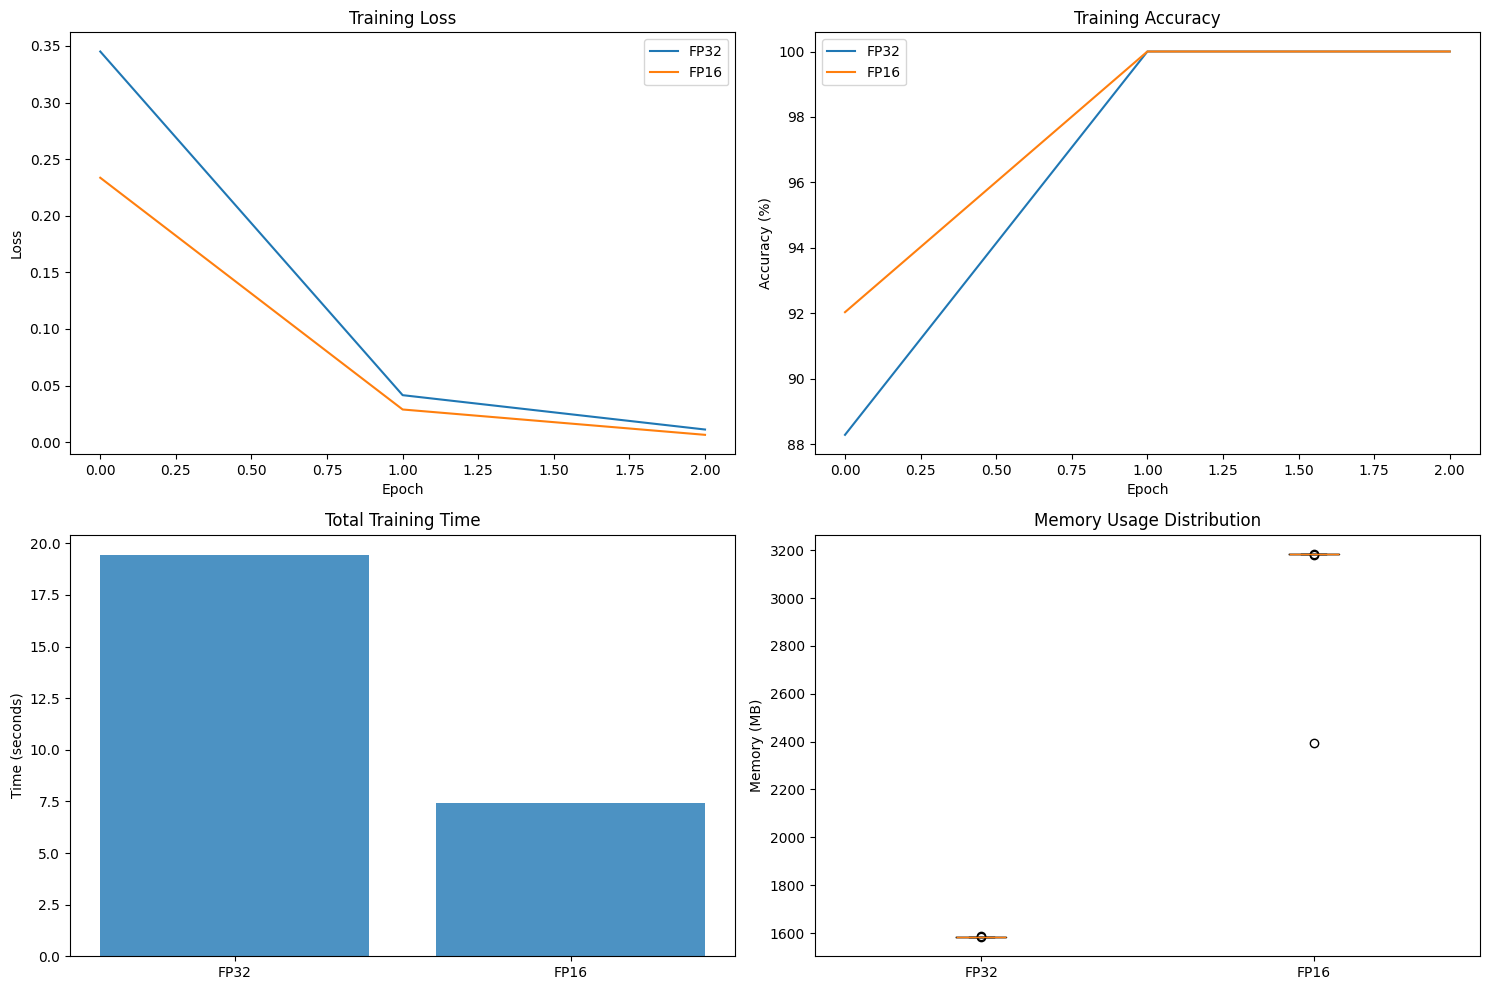


Detailed Statistics:
FP32:
Average training time per epoch: 6.48s
Average memory usage: 1584.9MB
Final accuracy: 100.00%

FP16:
Average training time per epoch: 2.48s
Average memory usage: 3171.7MB
Final accuracy: 100.00%

Performance Improvement:
Time reduction: 61.8%
Memory reduction: -100.1%


In [11]:
def plot_comparison(results_fp32, results_fp16):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # 损失对比
    ax1.plot(results_fp32[0], label='FP32')
    ax1.plot(results_fp16[0], label='FP16')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 准确率对比
    ax2.plot(results_fp32[1], label='FP32')
    ax2.plot(results_fp16[1], label='FP16')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    # 训练时间对比
    ax3.bar(['FP32', 'FP16'],
            [sum(results_fp32[2]), sum(results_fp16[2])],
            alpha=0.8)
    ax3.set_title('Total Training Time')
    ax3.set_ylabel('Time (seconds)')

    # 内存使用对比
    ax4.boxplot([results_fp32[3], results_fp16[3]], labels=['FP32', 'FP16'])
    ax4.set_title('Memory Usage Distribution')
    ax4.set_ylabel('Memory (MB)')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/mixed_precision_results/comparison.png')
    plt.show()

plot_comparison(results_fp32, results_fp16)

# 打印详细统计信息
print("\nDetailed Statistics:")
print("FP32:")
print(f"Average training time per epoch: {sum(results_fp32[2])/len(results_fp32[2]):.2f}s")
print(f"Average memory usage: {sum(results_fp32[3])/len(results_fp32[3]):.1f}MB")
print(f"Final accuracy: {results_fp32[1][-1]:.2f}%")

print("\nFP16:")
print(f"Average training time per epoch: {sum(results_fp16[2])/len(results_fp16[2]):.2f}s")
print(f"Average memory usage: {sum(results_fp16[3])/len(results_fp16[3]):.1f}MB")
print(f"Final accuracy: {results_fp16[1][-1]:.2f}%")

print("\nPerformance Improvement:")
time_improvement = (sum(results_fp32[2]) - sum(results_fp16[2])) / sum(results_fp32[2]) * 100
memory_improvement = (sum(results_fp32[3]) - sum(results_fp16[3])) / sum(results_fp32[3]) * 100
print(f"Time reduction: {time_improvement:.1f}%")
print(f"Memory reduction: {memory_improvement:.1f}%")

## 8. 推理性能比较

In [13]:
def inference_test(model, tokenizer, text, device, use_amp=False):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    start_time = time.time()
    with torch.no_grad():
        if use_amp:
            with autocast():
                outputs = model(input_ids, attention_mask)
        else:
            outputs = model(input_ids, attention_mask)

    inference_time = time.time() - start_time
    memory_used = torch.cuda.memory_allocated() / 1024**2

    probabilities = torch.softmax(outputs, dim=1)
    prediction = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][prediction].item()

    return prediction, confidence, inference_time, memory_used

# 测试文本
test_texts = [
    "这家餐厅的菜品非常美味，服务也很周到",
    "产品质量太差了，一点都不耐用",
    "这部电影剧情紧凑，演技在线"
]

# 加载模型进行推理
def load_model(model_path, device):
    model = TextClassifier(n_classes=2).to(device)
    model.load_state_dict(torch.load(model_path))
    return model

# 加载 FP32 模型
model_fp32 = load_model('/content/drive/MyDrive/mixed_precision_results/model_fp32.pth', device)

print("FP32 Inference:")
for text in test_texts:
    pred, conf, time_fp32, mem_fp32 = inference_test(model_fp32, tokenizer, text, device, use_amp=False)
    print(f"\n文本: {text}")
    print(f"预测: {'正面' if pred == 1 else '负面'}")
    print(f"置信度: {conf:.2%}")
    print(f"推理时间: {time_fp32*1000:.2f}ms")
    print(f"内存使用: {mem_fp32:.1f}MB")

# 加载 FP16 模型
model_fp16 = load_model('/content/drive/MyDrive/mixed_precision_results/model_fp16.pth', device)

print("\nFP16 Inference:")
for text in test_texts:
    pred, conf, time_fp16, mem_fp16 = inference_test(model_fp16, tokenizer, text, device, use_amp=True)
    print(f"\n文本: {text}")
    print(f"预测: {'正面' if pred == 1 else '负面'}")
    print(f"置信度: {conf:.2%}")
    print(f"推理时间: {time_fp16*1000:.2f}ms")
    print(f"内存使用: {mem_fp16:.1f}MB")

FP32 Inference:


NameError: name 'model_fp32' is not defined